查看4个文件的列名

In [1]:
import pandas as pd

files = {
    "comments_kaggle": "comments_kaggle_chinese.csv",
    "comments_xhs": "comments_xhs_chinese.csv",
    "posts_w": "posts_w_chinese.csv",
    "posts_xhs": "posts_xhs_chinese.csv"
}

data = []

for name, path in files.items():
    cols = pd.read_csv(path, nrows=0).columns.tolist()
    for col in cols:
        data.append({"File": name, "Column": col})

df_cols = pd.DataFrame(data)
print(df_cols)


               File             Column
0   comments_kaggle         comment_id
1   comments_kaggle        create_time
2   comments_kaggle      ip_location_x
3   comments_kaggle            note_id
4   comments_kaggle            content
5   comments_kaggle            user_id
6   comments_kaggle           nickname
7   comments_kaggle  sub_comment_count
8   comments_kaggle         like_count
9   comments_kaggle          processed
10  comments_kaggle            label_h
11  comments_kaggle        Unnamed: 11
12  comments_kaggle        Unnamed: 12
13  comments_kaggle        Unnamed: 13
14     comments_xhs            note_id
15     comments_xhs         comment_id
16     comments_xhs        create_time
17     comments_xhs      ip_location_y
18     comments_xhs            content
19     comments_xhs          user_id_y
20     comments_xhs         nickname_y
21     comments_xhs  sub_comment_count
22     comments_xhs       like_count_y
23     comments_xhs          processed
24     comments_xhs      

将4个文件的content和time和ip和label列挑出合并

In [2]:
import pandas as pd

files_info = {
    "comments_kaggle": {
        "path": "comments_kaggle_chinese.csv",
        "cols": ["create_time", "ip_location_x", "content", "label_h"],
        "rename": {"create_time": "time", "ip_location_x": "ip_location", "content": "text"},
    },
    "comments_xhs": {
        "path": "comments_xhs_chinese.csv",
        "cols": ["create_time", "ip_location_y", "content", "label_h"],
        "rename": {"create_time": "time", "ip_location_y": "ip_location", "content": "text"},
    },
    "posts_w": {
        "path": "posts_w_chinese.csv",
        "cols": ["time", "ip_location_x", "combined_text", "label_h"],
        "rename": {"ip_location_x": "ip_location", "combined_text": "text"},
    },
    "posts_xhs": {
        "path": "posts_xhs_chinese.csv",
        "cols": ["time", "ip_location_x", "combined_text", "label_h"],
        "rename": {"ip_location_x": "ip_location", "combined_text": "text"},
    },
}

dfs = []
for info in files_info.values():
    df = pd.read_csv(info["path"], usecols=info["cols"])
    df = df.rename(columns=info["rename"])
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

print(merged_df.head())

merged_df.to_csv("merged_comments_posts.csv", index=False, encoding="utf-8-sig")
print("merged_comments_posts.csv")


              time ip_location                             text  label_h
0   2025/1/16 1:06          美国                           我今年18歲      3.0
1  2025/1/15 12:05          美国  Thank you for helping us! 这是我的猫      1.0
2   2025/1/15 5:30          美国  My cat tax for the day  我今天的猫税。      1.0
3   2025/1/15 8:45          美国           Here's my cat .  这是我的猫      1.0
4   2025/1/15 4:26          美国            谢谢你的卡车警告哈哈我有狗，会努力学习中文      1.0
merged_comments_posts.csv


将标签列和非标签列的数据分开

In [3]:
import pandas as pd

labeled_df = merged_df[merged_df['label_h'].notna()]
unlabeled_df = merged_df[merged_df['label_h'].isna()]

print(len(merged_df))
print(len(labeled_df))
print(len(unlabeled_df))

labeled_df.to_csv("labeled_data.csv", index=False, encoding='utf-8-sig')
unlabeled_df.to_csv("unlabeled_data.csv", index=False, encoding='utf-8-sig')

print("labeled_data.csv")
print("unlabeled_data.csv")


7861
931
6930
labeled_data.csv
unlabeled_data.csv


数据预处理、检查处理后的缺失值并做处理

In [4]:
import pandas as pd
import jieba
import re

stopwords = set([
    "的", "了", "和", "是", "我", "也", "就", "都", "而", "及", "与", "着", "或", "一个",
    "没有", "我们", "你们", "他们", "她们", "它们", "是否", "自己", "不会", "不是"
])

def clean_and_tokenize(text):
    if pd.isna(text) or not str(text).strip():
        return None
    s = str(text).lower()
    s = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9]", "", s)
    if not s.strip():
        return None
    words = jieba.lcut(s)
    words = [w for w in words if w.strip() and w not in stopwords]
    return " ".join(words) if words else None

df_labeled = pd.read_csv("labeled_data.csv", encoding="utf-8-sig")
df_labeled["text"] = df_labeled["text"].apply(clean_and_tokenize)
df_labeled = df_labeled.dropna(subset=["text"])
print(len(df_labeled))
print(df_labeled.isnull().sum())
df_labeled.to_csv("labeled_data_final.csv", index=False, encoding="utf-8-sig")

df_unlabeled = pd.read_csv("unlabeled_data.csv", encoding="utf-8-sig")
df_unlabeled["text"] = df_unlabeled["text"].apply(clean_and_tokenize)
df_unlabeled = df_unlabeled.dropna(subset=["text"])
print(len(df_unlabeled))
print(df_unlabeled.isnull().sum())
df_unlabeled.to_csv("unlabeled_data_final.csv", index=False, encoding="utf-8-sig")


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HUAWEI\AppData\Local\Temp\jieba.cache
Loading model cost 1.406 seconds.
Prefix dict has been built successfully.


930
time           0
ip_location    0
text           0
label_h        0
dtype: int64
6653
time              0
ip_location       0
text              0
label_h        6653
dtype: int64


用TF–IDF

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.model_selection import train_test_split

df = pd.read_csv("labeled_data_final.csv", encoding="utf-8-sig")
corpus = df["text"].tolist()

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    token_pattern=r"(?u)\b\w+\b"
)
X_tfidf = vectorizer.fit_transform(corpus)

print(X_tfidf.shape)

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out()
)
tfidf_df.to_csv("tfidf_features.csv", index=False, encoding="utf-8-sig")

y = df["label_h"]
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)


(930, 1441)
(744, 1441) (186, 1441)


使用各个模型进行训练(最终是用了这个模型去预测了)

In [6]:
import pandas as pd
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

df = pd.read_csv("labeled_data_final.csv", encoding="utf-8-sig")

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    token_pattern=r"(?u)\b\w+\b"
)
X = vectorizer.fit_transform(df["text"])
y = df["label_h"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel="linear", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Multinomial NB": MultinomialNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
}

best_model_name = None
best_model_obj = None
best_f1 = 0.0

for name, model in models.items():
    if name == "LightGBM":
        X_tr, X_te = X_train.toarray(), X_test.toarray()
    else:
        X_tr, X_te = X_train, X_test

    model.fit(X_tr, y_train_enc)
    pred_enc = model.predict(X_te)
    y_pred = le.inverse_transform(pred_enc)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    print(name)
    print(f"{acc:.4f}", f"{prec:.4f}", f"{rec:.4f}", f"{f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name
        best_model_obj = model

print(best_model_name, f"{best_f1:.4f}")

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(best_model_obj, f"{best_model_name.replace(' ', '_')}_best_model.pkl")
print("模型已保存")


Logistic Regression
0.6398 0.7179 0.6398 0.5487
              precision    recall  f1-score   support

         1.0       0.63      0.98      0.77       110
         2.0       1.00      0.04      0.07        26
         3.0       0.77      0.20      0.32        50

    accuracy                           0.64       186
   macro avg       0.80      0.41      0.39       186
weighted avg       0.72      0.64      0.55       186

Decision Tree
0.6129 0.5697 0.6129 0.5817
              precision    recall  f1-score   support

         1.0       0.68      0.84      0.75       110
         2.0       0.23      0.12      0.15        26
         3.0       0.50      0.38      0.43        50

    accuracy                           0.61       186
   macro avg       0.47      0.44      0.45       186
weighted avg       0.57      0.61      0.58       186

Random Forest
0.6237 0.6192 0.6237 0.5537
              precision    recall  f1-score   support

         1.0       0.63      0.93      0.75       1

d:\Program Files\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:08:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
0.6237 0.5846 0.6237 0.5819
              precision    recall  f1-score   support

         1.0       0.66      0.87      0.75       110
         2.0       0.27      0.12      0.16        26
         3.0       0.59      0.34      0.43        50

    accuracy                           0.62       186
   macro avg       0.51      0.44      0.45       186
weighted avg       0.58      0.62      0.58       186

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 744, number of used features: 152
[LightGBM] [Info] Start training from score -0.532108
[LightGBM] [Info] Start training from score -1.958081
[LightGBM] [Info] Start training from score -1.303773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

d:\Program Files\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


模型对比可视化

Logistic Regression


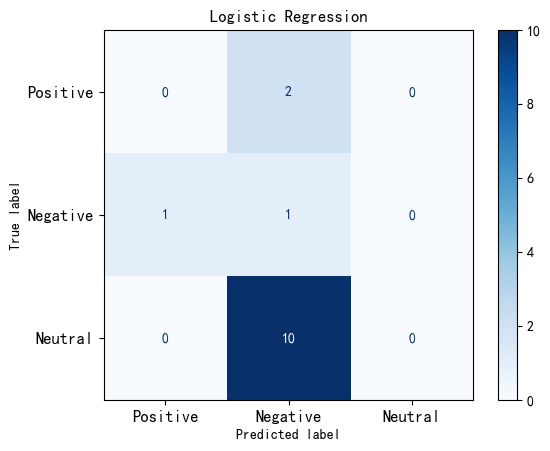

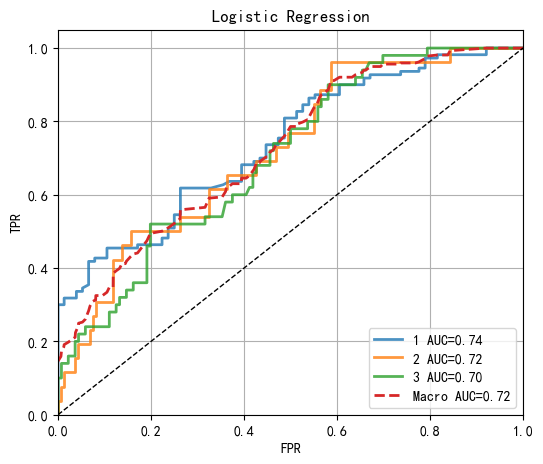

Decision Tree


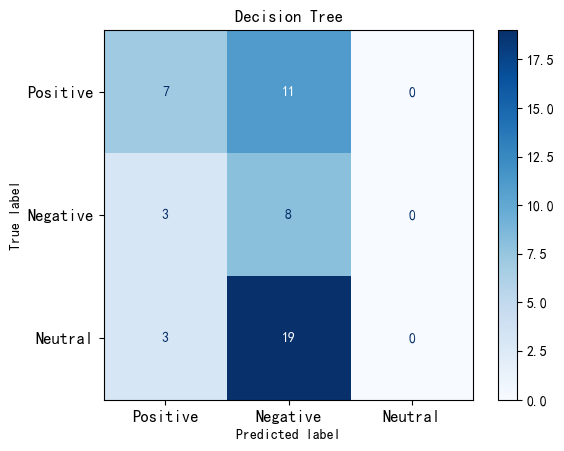

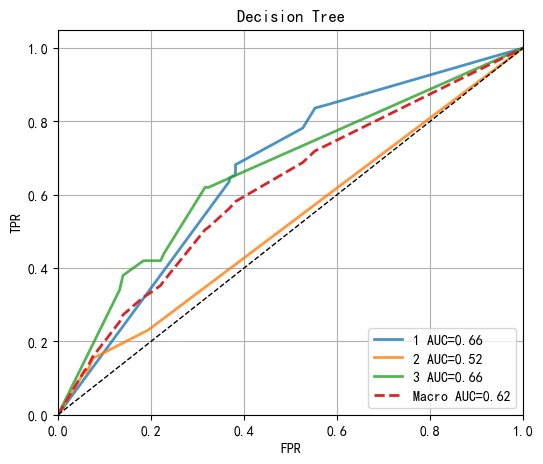

Random Forest


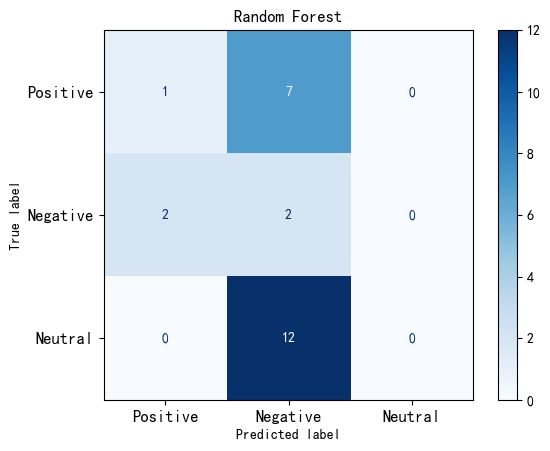

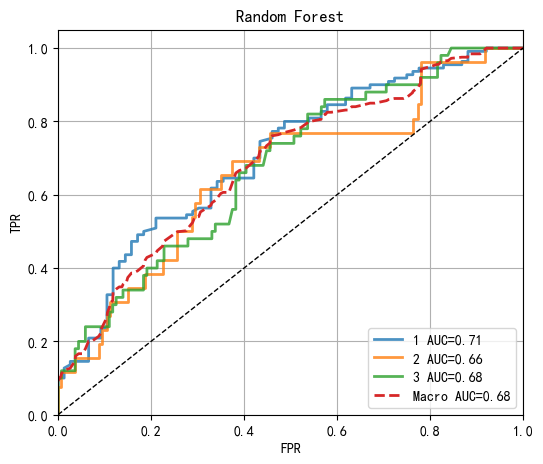

SVM


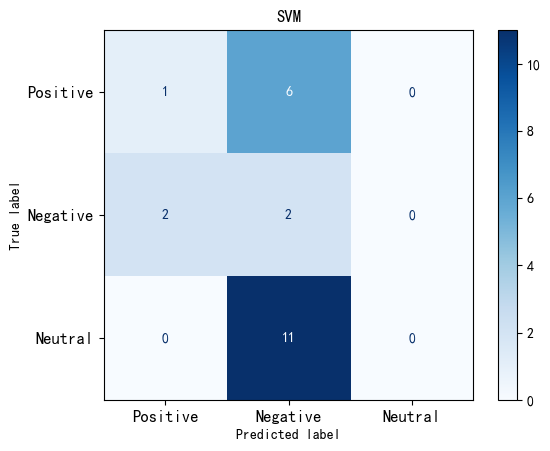

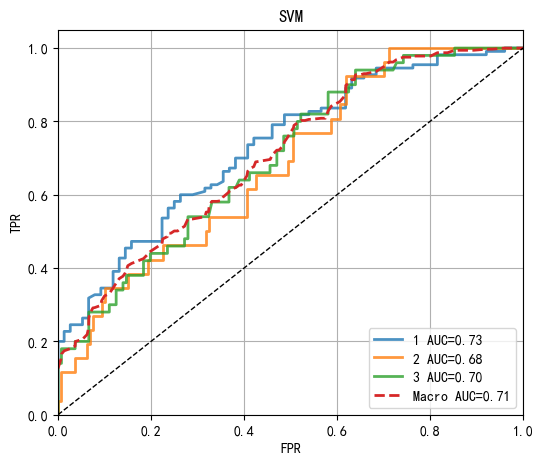

KNN


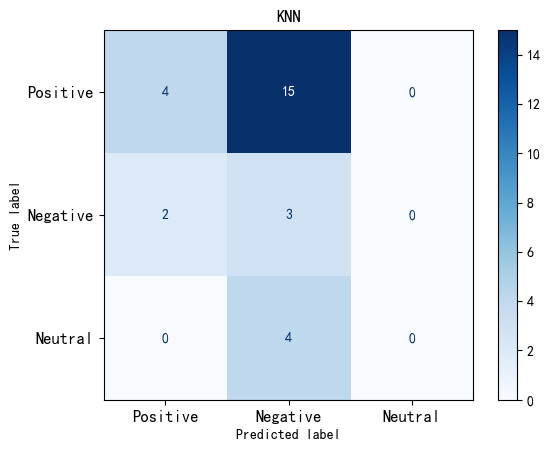

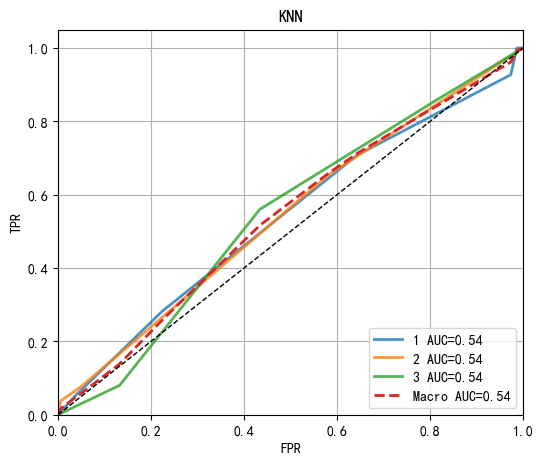

Multinomial NB


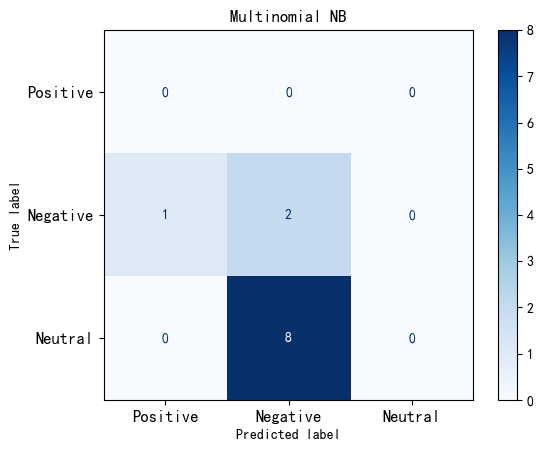

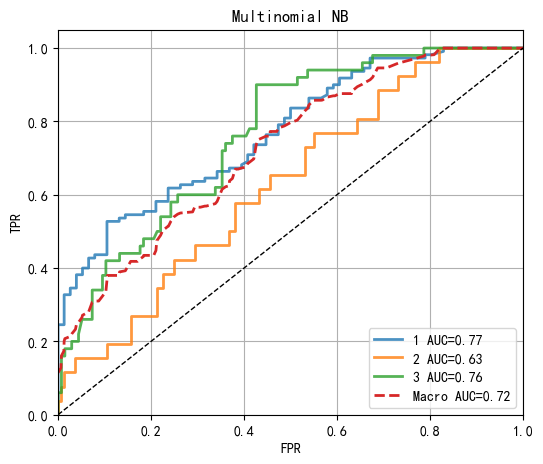

AdaBoost


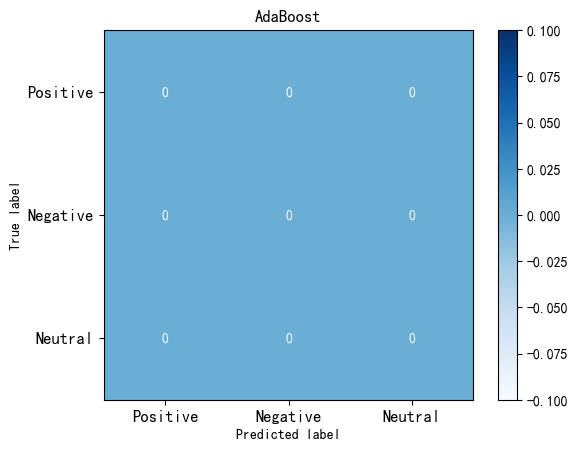

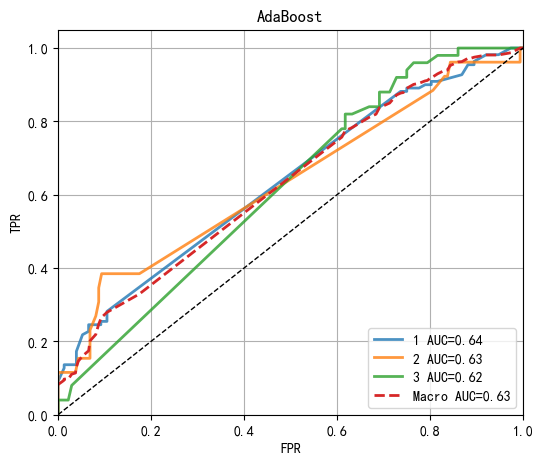

GBDT


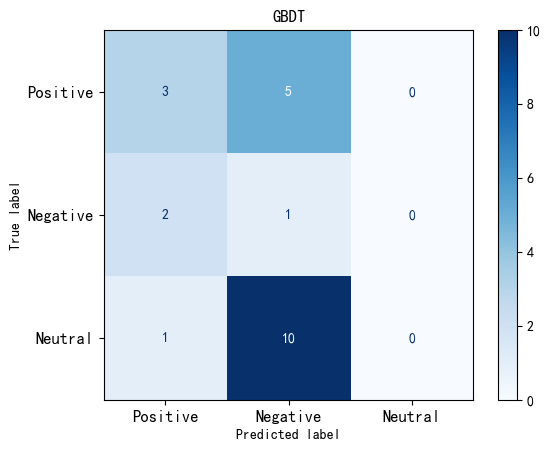

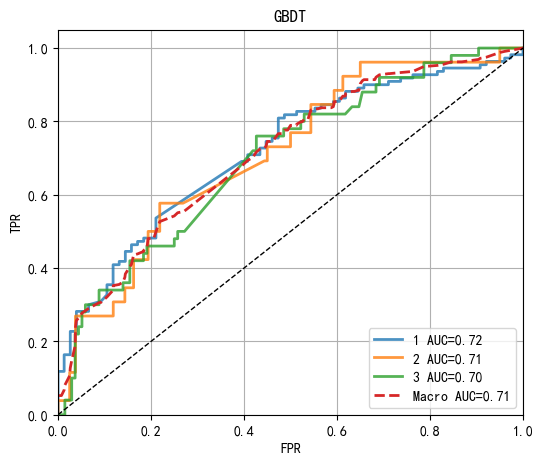

Extra Trees


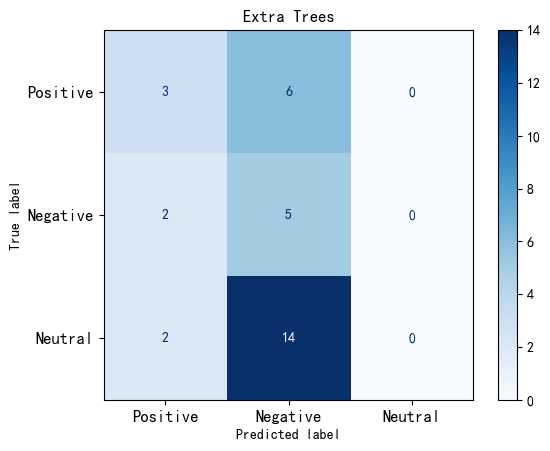

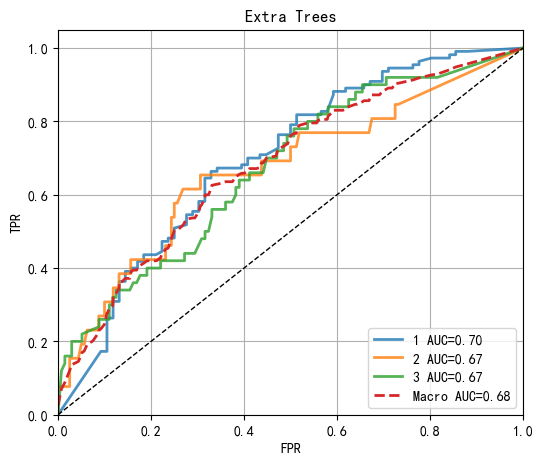

MLP (Neural Net)


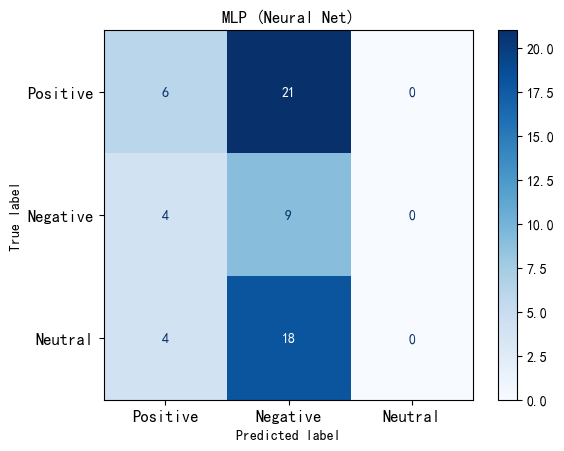

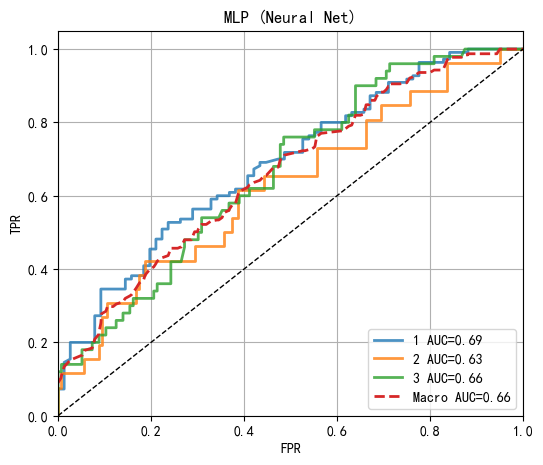

XGBoost


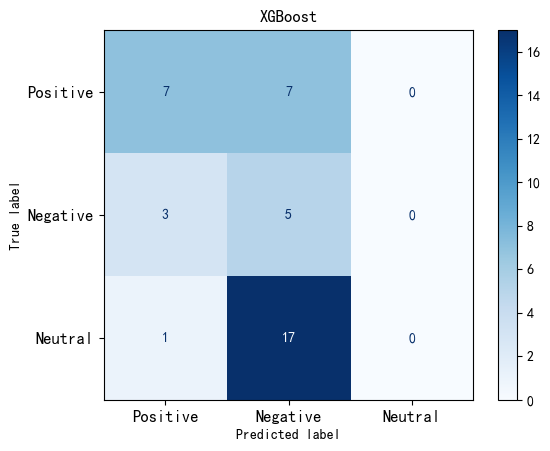

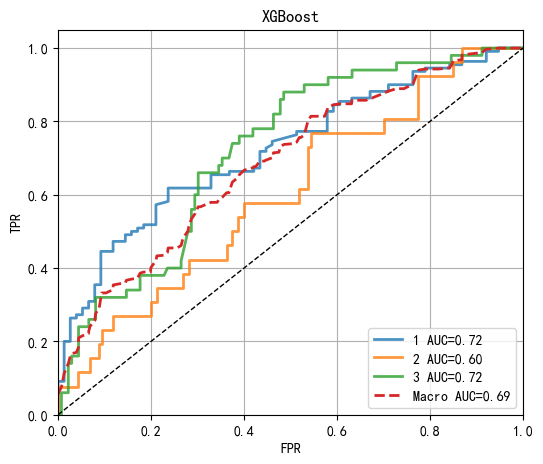

LightGBM


d:\Program Files\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


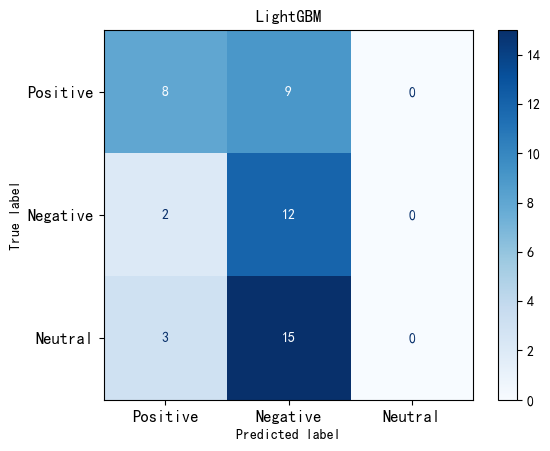

d:\Program Files\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


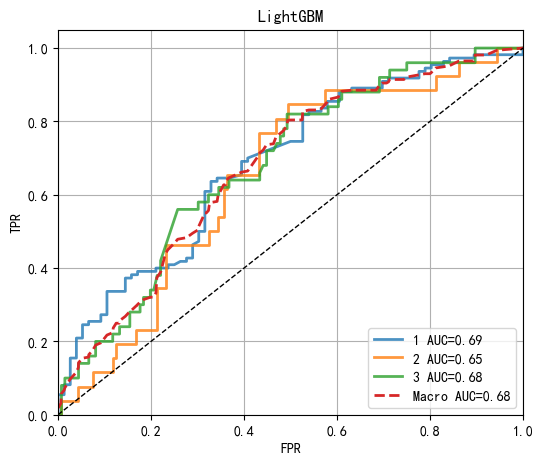

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

for name, model in models.items():
    print(name)

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
    disp = ConfusionMatrixDisplay(cm, display_labels=["Positive", "Negative", "Neutral"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(name)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        scores = model.decision_function(X_test)
        y_score = (scores - scores.min()) / (scores.max() - scores.min())

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(6, 5))
    colors = ["aqua", "darkorange", "cornflowerblue"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], label=f"{i+1} AUC={roc_auc[i]:.2f}", linewidth=2, alpha=0.8)
    plt.plot(fpr["macro"], tpr["macro"], label=f"Macro AUC={roc_auc['macro']:.2f}", linestyle='--', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(name)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.show()


对 XGBoost 和 LightGBM 做 5 折交叉验证的网格搜索（GridSearchCV），以 weighted‑F1 为指标，找出最优超参数

（这个效果很差，最后没有用这部分，只是展示了一个过程）

In [11]:
import pandas as pd
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

df = pd.read_csv("labeled_data_final.csv", encoding="utf-8-sig")
texts = df["text"]
labels = df["label_h"]

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")
X = vectorizer.fit_transform(texts)

X_train, X_val, y_train, y_val = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

f1_weighted = make_scorer(f1_score, average="weighted", zero_division=0)

xgb = XGBClassifier(objective="multi:softprob", random_state=42, use_label_encoder=False, eval_metric="mlogloss")
xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

gs_xgb = GridSearchCV(
    xgb,
    xgb_param_grid,
    scoring=f1_weighted,
    cv=5,
    n_jobs=-1,
    verbose=2
)
gs_xgb.fit(X_train, y_train_enc)

print("Best params (XGBoost):", gs_xgb.best_params_)
print("Best weighted-F1 (XGBoost):", gs_xgb.best_score_)

lgbm = LGBMClassifier(objective="multiclass", random_state=42)
lgbm_param_grid = {
    "num_leaves": [31, 50, 80],
    "max_depth": [-1, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "feature_fraction": [0.7, 0.8, 1.0],
    "bagging_fraction": [0.7, 0.8, 1.0]
}

gs_lgbm = GridSearchCV(
    lgbm,
    lgbm_param_grid,
    scoring=f1_weighted,
    cv=5,
    n_jobs=-1,
    verbose=2
)
gs_lgbm.fit(X_train.toarray(), y_train_enc)

print("Best params (LightGBM):", gs_lgbm.best_params_)
print("Best weighted-F1 (LightGBM):", gs_lgbm.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


d:\Program Files\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:20:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params (XGBoost): {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
Best weighted-F1 (XGBoost): 0.5510073637484656
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 744, number of used feature

bert-base-chinese 来做中文情感微调

微调的结果也很差，最终也是没用这部分，只是展示一下

In [12]:
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate
import pandas as pd

df = pd.read_csv("labeled_data_final.csv", encoding="utf-8-sig")
df = df.sample(500, random_state=42).reset_index(drop=True)
df["label_h"] = df["label_h"].astype(int) - 1  # 0,1,2

split = df.sample(frac=0.2, random_state=42)
train_df = df.drop(split.index).reset_index(drop=True)
valid_df = split.reset_index(drop=True)

raw_datasets = DatasetDict({
    "train":      Dataset.from_pandas(train_df[["text","label_h"]]),
    "validation": Dataset.from_pandas(valid_df[["text","label_h"]])
})

# ——— Tokenizer & preprocess_fn ——
model_name = "bert-base-chinese"
tokenizer  = AutoTokenizer.from_pretrained(model_name)

def preprocess_fn(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,
        padding="max_length",
    )
    tokenized["labels"] = examples["label_h"]
    return tokenized

tokenized = raw_datasets.map(preprocess_fn, batched=True)

num_labels = len(df["label_h"].unique())
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1":       metric_f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

training_args = TrainingArguments(
    output_dir="./bert_finetune",
    evaluation_strategy   ="steps",
    eval_steps            =100,
    save_steps            =200,
    logging_steps         =50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size =32,
    learning_rate         =2e-5,
    num_train_epochs      =4,
    load_best_model_at_end=True,
    metric_for_best_model ="f1",
    greater_is_better     =True,
    seed                  =42,
)

trainer = Trainer(
    model           =model,
    args            =training_args,
    train_dataset   =tokenized["train"],
    eval_dataset    =tokenized["validation"],
    tokenizer       =tokenizer,
    compute_metrics =compute_metrics,
)

trainer.train()


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Program Files\Python\Python313\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_12852\1716967124.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
100,0.635900,0.869851,0.590000,0.564302


TrainOutput(global_step=100, training_loss=0.7647099304199219, metrics={'train_runtime': 475.3075, 'train_samples_per_second': 3.366, 'train_steps_per_second': 0.21, 'total_flos': 105245367091200.0, 'train_loss': 0.7647099304199219, 'epoch': 4.0})

用了第一种方法训练出来的模型进行预测了

In [13]:
import pandas as pd
import joblib
import re, jieba

df_unlabeled = pd.read_csv("unlabeled_data.csv", encoding="utf-8-sig")

stopwords = {
    "的", "了", "和", "是", "我", "也", "就", "都", "而", "及", "与", "着", "或", "一个",
    "没有", "我们", "你们", "他们", "她们", "它们", "是否", "自己", "不会", "不是"
}

def clean_and_tokenize(text):
    if pd.isna(text) or not str(text).strip():
        return None
    s = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9]", "", str(text).lower())
    words = [w for w in jieba.lcut(s) if w not in stopwords and w.strip()]
    return " ".join(words) if words else None

df_unlabeled["text"] = df_unlabeled["text"].apply(clean_and_tokenize)
df_unlabeled = df_unlabeled.dropna(subset=["text"]).reset_index(drop=True)

vectorizer = joblib.load("tfidf_vectorizer.pkl")
model = joblib.load("XGBoost_best_model.pkl")

X_unlabeled = vectorizer.transform(df_unlabeled["text"])
pred_enc = model.predict(X_unlabeled)
mapping = {0: 1, 1: 2, 2: 3}
df_unlabeled["predicted_label"] = [mapping[p] for p in pred_enc]

df_unlabeled.to_csv("unlabeled_with_predictions.csv", index=False, encoding="utf-8-sig")
print("Prediction completed. Saved to: unlabeled_with_predictions.csv")


Prediction completed. Saved to: unlabeled_with_predictions.csv


把预测好的数据集和之前有标签的数据集合在一起

In [14]:
import pandas as pd

labeled_df = pd.read_csv("labeled_data_final.csv")
unlabeled_df = pd.read_csv("unlabeled_with_predictions.csv")

if "label_h" in unlabeled_df.columns:
    unlabeled_df = unlabeled_df.drop(columns=["label_h"])

labeled_df["final_label"] = labeled_df["label_h"]
unlabeled_df["final_label"] = unlabeled_df["predicted_label"]

combined_df = pd.concat([labeled_df, unlabeled_df], axis=0, ignore_index=True)

combined_df = combined_df.drop(columns=[col for col in ["predicted_label", "label_h"] if col in combined_df.columns])

output_path = "combined_cleaned_final.csv"
combined_df.to_csv(output_path, index=False, encoding="utf-8-sig")

combined_df.head()

,time,ip_location,text,final_label
0,2025/1/16 1:06,美国,今年 18 歲,3.0
1,2025/1/15 12:05,美国,thankyouforhelpingus 这 猫,1.0
2,2025/1/15 5:30,美国,mycattaxfortheday 今天 猫 税,1.0
3,2025/1/15 8:45,美国,heresmycat 这 猫,1.0
4,2025/1/15 4:26,美国,谢谢 你 卡车 警告 哈哈 有 狗 会 努力学习 中文,1.0


可视化

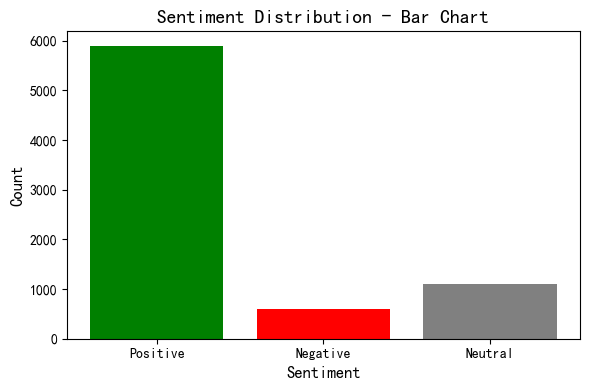

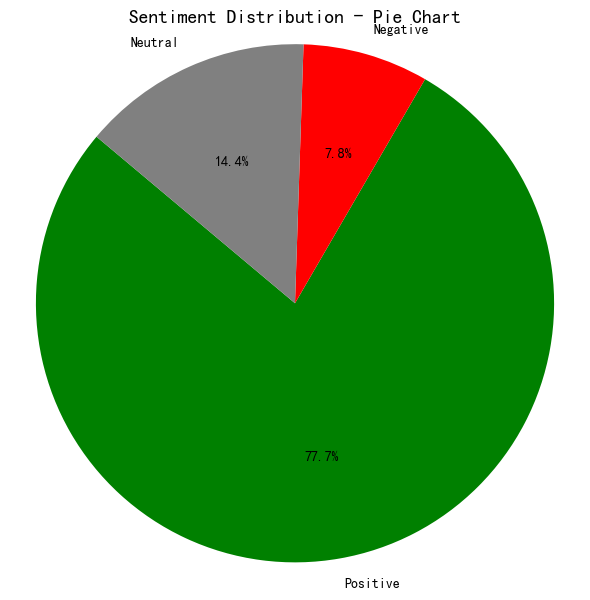

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("combined_cleaned_final.csv")

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

sentiment_counts = df["final_label"].value_counts().sort_index()
labels_map = {1: "Positive", 2: "Negative", 3: "Neutral"}
labels = [labels_map[i] for i in sentiment_counts.index]
sizes = sentiment_counts.values

plt.figure(figsize=(6, 4))
plt.bar(labels, sizes, color=["green", "red", "gray"])
plt.title("Sentiment Distribution - Bar Chart", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=["green", "red", "gray"], startangle=140)
plt.title("Sentiment Distribution - Pie Chart", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()


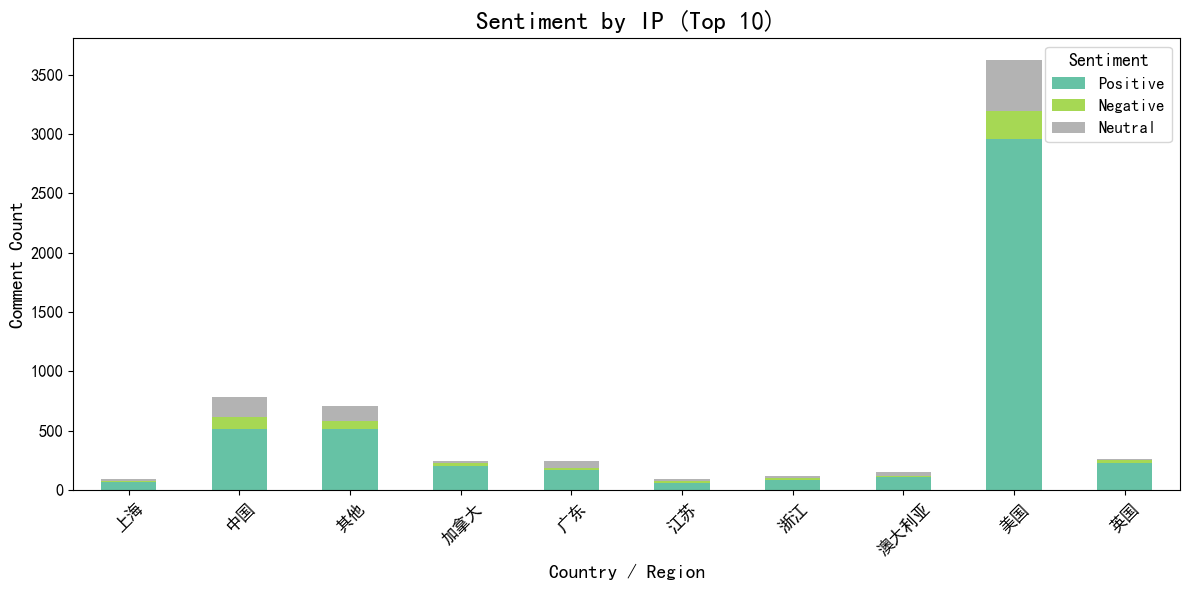

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("combined_cleaned_final.csv", encoding="utf-8-sig")
df = df.dropna(subset=["ip_location", "final_label"])

top_countries = df["ip_location"].value_counts().nlargest(10).index
df_top = df[df["ip_location"].isin(top_countries)]

country_sentiment_counts = df_top.groupby(["ip_location", "final_label"]).size().unstack(fill_value=0)
sentiment_map = {1: "Positive", 2: "Negative", 3: "Neutral"}
country_sentiment_counts.columns = [sentiment_map.get(col, col) for col in country_sentiment_counts.columns]

ax = country_sentiment_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="Set2")
ax.set_title("Sentiment by IP (Top 10)", fontsize=18)
ax.set_xlabel("Country / Region", fontsize=14)
ax.set_ylabel("Comment Count", fontsize=14)
ax.legend(title="Sentiment", fontsize=12, title_fontsize=13)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


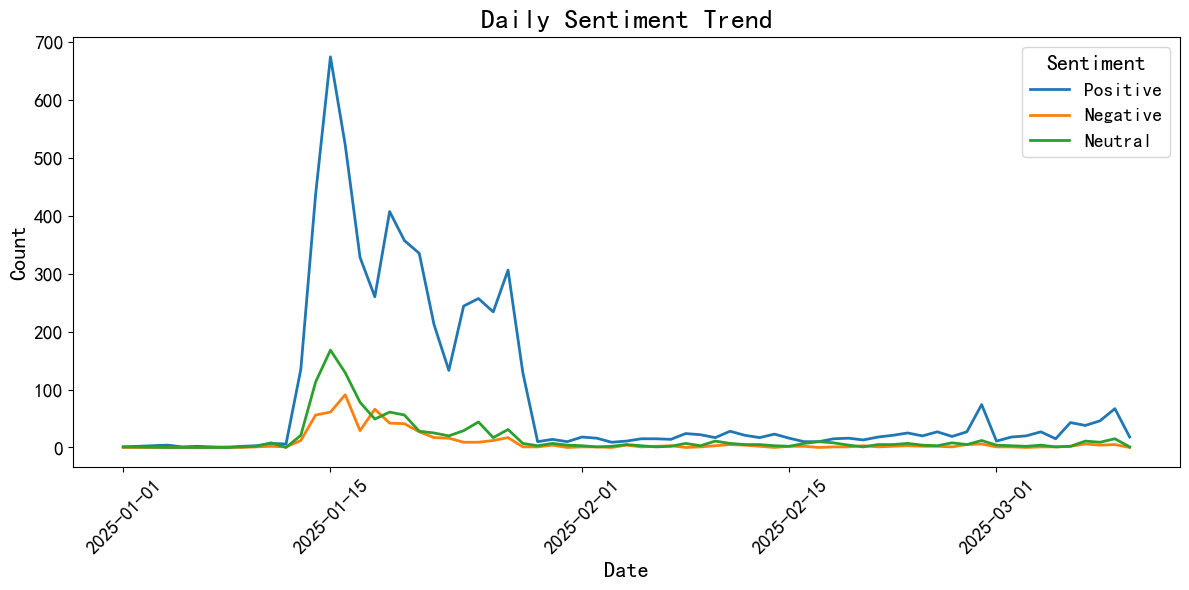

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("combined_cleaned_final.csv")
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time", "final_label"])
df["date"] = df["time"].dt.date

daily_counts = df.groupby(["date", "final_label"]).size().unstack().fillna(0)

ax = daily_counts.plot(marker='', linewidth=2, figsize=(12, 6))
ax.set_title("Daily Sentiment Trend", fontsize=20)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)
ax.legend(["Positive", "Negative", "Neutral"], title="Sentiment", fontsize=14, title_fontsize=16, loc="upper right")

plt.tight_layout()
plt.show()
